In [1]:
%load_ext autoreload
%autoreload

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import pandas as pd
import numpy as np
import os

from glob import glob
import json
from tqdm import tqdm

sys.path.append('/home/link/Project/KoBertSum_1')
sys.path.append('/home/link/Project/KoBertSum_1/src')
tqdm.pandas()

In [4]:
import os
import pickle
from typing import Collection

def save_obj(collection: Collection, file_path: str, proc_type: str = "pickle"):
    # file_name, file_extension = os.path.splitext(os.path.basename(file_path))
    # dir_path = os.path.dirname(os.path.abspath(file_path))

    if proc_type == "pickle":
        with open(file_path, "wb") as f:
            pickle.dump(collection, f)

    elif proc_type == "plain":
        with open(file_path, "w") as f:
            f.write("\n".join(collection))


def load_obj(file_path: str, proc_type: str = "pickle"):
    # file_name, file_extension = os.path.splitext(os.path.basename(file_path))
    # dir_path = os.path.dirname(os.path.abspath(file_path))

    if proc_type == "pickle":
        try:
            with open(file_path, "rb") as f:
                return pickle.load(f)
        except Exception as expt:
            print(f"ERROR: {expt}")
            print("This file is not for pickle. Load it as plain load method")
            proc_type = "plain"

    if proc_type == "plain":
        with open(file_path, "r") as f:
            lines = f.read().splitlines()
            return lines


# 데이터 로드

In [5]:
DATA_PATH = "/home/link/Project/KoBertSum_1/datasets/hunmin_ko"
train_orig_df = pd.read_csv(f"{DATA_PATH}/orig/train_data.csv")
test_orig_df = pd.read_csv(f"{DATA_PATH}/orig/test_data.csv")
sample_submission_df = pd.read_csv(f"{DATA_PATH}/orig/sample_submission.csv")

In [7]:
train_orig_df

,id,text,summary
0,0,원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해...,원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 ...
1,1,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 같은 그룹내 종합무역상사인 소외 ...,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 소외 회사의 직수출실적을 지원하기...
2,2,가등기담보권자가 제소전 화해조항에 따라 자기 명의로 소유권이전의 본등기를 경료한 후...,가등기담보권자가 제소전 화해조항에 의해 자기 명의로 소유권이전의 본등기를 경료하고 ...
3,3,가. 부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 뜻은 ...,부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 의미는 제1...
4,4,소득세법 제116조 제1항의 규정에 의하면 정부는 과세표준확정신고를 하여야 할 자에...,소득세법 제116조 제1항에 따르면 정부는 과세표준확정신고를 해야 할 자에 대해 당...
...,...,...,...
271660,271660,KCGI는 지분 늘려 13.47%로 국민연금과 합치면 20% 넘어 '백기사' 확보 ...,8일 IB업계 관계자는 상속세 납부 과정에서 조 회장 일가의 한진칼 지배구조 약화 ...
271661,271661,"[ 노유정 기자 ] 조양호 한진그룹 회장의 갑작스런 타계 소식이 전해진 8일 오전,...",8일 미국에서 들려온 조양호 한진그룹 회장의 사망 소식에 서울 공항동 대한항공 본사...
271662,271662,[ 김익환 기자 ] 조양호 한진그룹 회장이 타계하면서 그의 재산을 물려받을 장남 조...,"고 조 회장의 한진칼, 한진 등 상장회사의 주식가격 총합은 약 3560억 정도 되며..."
271663,271663,[ 김보형 기자 ] 조양호 한진그룹 회장이 8일 타계하면서 그의 장남인 조원태 대한...,"지난 8일 조양호 한진그룹 회장이 별세하면서 한진그룹은 비상경영체제에 돌입했고, 그..."


In [10]:
test_orig_df.head()

,id,text,summary
0,1,[경주=환경일보] 강광태 기자 = 경주시는 창의적 아이디어를 적극 수렴함으로써 소통...,생성요약문
1,2,"황영민 시장·군수·구청장 직접 제출… 경기도, 복지부·국회에 개선 요구 경기도가 장...",생성요약문
2,3,김대연 기자l saint-jj@hanmail.net 전북도의회는 올해 의회운영의 전...,생성요약문
3,4,대법원 2부(주심 안철상)는 스타 강사 우모씨를 상대로 인터넷 강의 업체 이투스교육...,생성요약문
4,5,"사설 보호무역 확산, G20회의 철저한 준비를 1월 수출이 월별 수출입 동향을 집계...",생성요약문


In [12]:
test_orig_df.shape

(10000, 3)

In [15]:
sample_submission_df.head()

,id,summary
0,1,생성요약문
1,2,생성요약문
2,3,생성요약문
3,4,생성요약문
4,5,생성요약문


In [16]:
sample_submission_df.shape

(10000, 2)

# 데이터 전처리

In [6]:
train_df = train_orig_df.copy()
test_df = test_orig_df.copy()

### 클리닝1

In [7]:
#결측치 제거
nan_list = [27556, 34092, 34201, 66897, 133273, 216203]
train_df = train_df[~train_df["id"].isin(nan_list)].reset_index(drop = True)

In [8]:
train_df[train_df["summary"].isna()]
# train_data[train_data['text'].apply(lambda x : type(x) is not str)]

,id,text,summary


In [9]:
train_df[train_df["summary"].str.len() < 10]

,id,text,summary


In [12]:
save_obj(train_df, f"{DATA_PATH}/df_tmp/train_df.pickle")
save_obj(test_df, f"{DATA_PATH}/df_tmp/test_df.pickle")

### 클리닝2

In [41]:
train_cleand = train_df.copy()
test_cleand = test_df.copy()

train_df[train_df['id']==271567]['text'].values

array(['[ 김보라 기자 ] 본죽을 운영하는 본아이에프 연간 매출이 2000억원을 돌파했다. 최저임금 인상, 가정간편식(HMR) 공세, 각종 식재료 가격 상승 프랜차이즈업계를 덮친 악재 속에 거둔 성과다. 2002년 9월 대학로에서 5000만원짜리 가게로 시작한 죽집은 "아픈 사람이 먹는 죽이 돈이 되겠냐"는 고정관념을 깨고 종합식품기업으로 성장하고 있다.'],
      dtype=object)

In [42]:
from prepro.preprocessor_kr import noise_remove

train_cleand['text'] = train_cleand['text'].progress_apply(noise_remove)
test_cleand['text'] = test_cleand['text'].progress_apply(noise_remove)

train_cleand[train_cleand['id']==271567]['text'].values

100%|██████████| 10000/10000 [00:10<00:00, 957.45it/s]


array(['본죽을 운영하는 본아이에프 연간 매출이 2000억원을 돌파했다. 최저임금 인상, 가정간편식 공세, 각종 식재료 가격 상승 프랜차이즈업계를 덮친 악재 속에 거둔 성과다. 2002년 9월 대학로에서 5000만원짜리 가게로 시작한 죽집은 "아픈 사람이 먹는 죽이 돈이 되겠냐"는 고정관념을 깨고 종합식품기업으로 성장하고 있다.'],
      dtype=object)

In [43]:
print(train_cleand['text'][271567])

] 액정표시장치 업황 부진에 유가증권시장에서 추락을 거듭하던 LG디스플레이가 최근 회복세를 보여 눈길을 끌고 있다. LCD 패널 가격 하락세가 잦아든 데다 미래 먹거리인 유기발광다이오드 사업의 성장성이 부각된 점이 투자심리 개선으로 이어졌다는 분석이다.


In [ ]:
save_obj(train_cleand, f"{DATA_PATH}/df_tmp/train_cleand.pickle")
save_obj(test_cleand, f"{DATA_PATH}/df_tmp/test_cleand.pickle")

## 문장 나누기

In [46]:
train_cleand_splited = train_cleand.copy()
test_cleand_splited = test_cleand.copy()

In [44]:
import functools
from kss import split_sentences
kss_split_sent = functools.partial(
    split_sentences,
    use_heuristic=False,
    use_quotes_brackets_processing=False,
    max_recover_step=3,
    max_recover_length=1000,
    backend="mecab",
    num_workers=28,
    disable_gc=True,
)

In [33]:
print(train_cleand_splited['text'][18804])
# print(kss_split_sent(train_data['text'][18804]))  # 오류남 쌍 quate 안에 짝이 안맞는 quate가 들어가있는 경우
kss_split_sent(train_cleand_splited['text'][18804].replace("McDONALD'S", r"McDONALD'''"))

가. 등록서비스표 는 문자의 서체나 구성상 첫 글자보다 다음 글자가 점점 작게 표기되어 있어 그 구성상 일련 불가분적으로 결합된 조어로 인식되므로 인용서비스표 인 "맥도날드", "McDONALD'S"와 사이에 그 식별력을 부인할 수 없고, 칭호에 있어서 등록서비스표 는 "맥코리아"로 호칭되나 인용서비스표 는 "맥도날드"로 호칭될 것이어서 양 서비스표 는 외관, 칭호, 관념이 상이한 것이어서 객관적, 전체적, 이격적으로 관찰할 때 유사한 서비스표 라고 할 수 없다.


['가.',
 '등록서비스표 는 문자의 서체나 구성상 첫 글자보다 다음 글자가 점점 작게 표기되어 있어 그 구성상 일련 불가분적으로 결합된 조어로 인식되므로 인용서비스표 인 "맥도날드", "McDONALD\'\'\'"와 사이에 그 식별력을 부인할 수 없고, 칭호에 있어서 등록서비스표 는 "맥코리아"로 호칭되나 인용서비스표 는 "맥도날드"로 호칭될 것이어서 양 서비스표 는 외관, 칭호, 관념이 상이한 것이어서 객관적, 전체적, 이격적으로 관찰할 때 유사한 서비스표 라고 할 수 없다.']

In [45]:
import re
single_quate_not_pair_rpat = re.compile(r"(\"[^'\"]*)'([^'\"]*\")")
double_quate_not_pair_rpat = re.compile(r"(\'[^'\"]*)\"([^'\"]*\')")

def cleaner(text):
    text = single_quate_not_pair_rpat.sub(r"\1 \2", text)
    text = double_quate_not_pair_rpat.sub(r"\1 \2", text)
    return text

In [47]:
train_cleand_splited['text'] = train_cleand_splited['text'].apply(cleaner)
train_cleand_splited['summary'] = train_cleand_splited['summary'].apply(cleaner)
test_cleand_splited['text'] = test_cleand_splited['text'].apply(cleaner)

In [48]:
train_cleand_splited

,id,text,summary
0,0,원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해...,원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 ...
1,1,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 같은 그룹내 종합무역상사인 소외 ...,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 소외 회사의 직수출실적을 지원하기...
2,2,가등기담보권자가 제소전 화해조항에 따라 자기 명의로 소유권이전의 본등기를 경료한 후...,가등기담보권자가 제소전 화해조항에 의해 자기 명의로 소유권이전의 본등기를 경료하고 ...
3,3,가. 부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 뜻은 ...,부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 의미는 제1...
4,4,소득세법 제116조 제1항의 규정에 의하면 정부는 과세표준확정신고를 하여야 할 자에...,소득세법 제116조 제1항에 따르면 정부는 과세표준확정신고를 해야 할 자에 대해 당...
...,...,...,...
271654,271660,KCGI는 지분 늘려 13.47%로 국민연금과 합치면 20% 넘어 '백기사' 확보 ...,8일 IB업계 관계자는 상속세 납부 과정에서 조 회장 일가의 한진칼 지배구조 약화 ...
271655,271661,"조양호 한진그룹 회장의 갑작스런 타계 소식이 전해진 8일 오전, 서울 공항동 대한항...",8일 미국에서 들려온 조양호 한진그룹 회장의 사망 소식에 서울 공항동 대한항공 본사...
271656,271662,조양호 한진그룹 회장이 타계하면서 그의 재산을 물려받을 장남 조원태 대한항공 사장 ...,"고 조 회장의 한진칼, 한진 등 상장회사의 주식가격 총합은 약 3560억 정도 되며..."
271657,271663,조양호 한진그룹 회장이 8일 타계하면서 그의 장남인 조원태 대한항공 사장 의 '3세...,"지난 8일 조양호 한진그룹 회장이 별세하면서 한진그룹은 비상경영체제에 돌입했고, 그..."


In [50]:
print(len(train_cleand_splited))
print(len(test_cleand_splited))

271659
10000


In [ ]:
for df_total in [train_cleand_splited, test_cleand_splited]
    dfs_split = np.array_split(df_total, 100)
    srs = []
    for df in tqdm(dfs_split):
        part_sr = pd.Series()
        ids = df['id'].values
        print(ids[0], ids[-1])
        # print(list(df['text'].values))
        part_text_sr = pd.Series(kss_split_sent(list(df['text'].values)))
        assert len(part_text_sr) == len(df['text'])
        part_summary_sr = pd.Series(kss_split_sent(list(df['summary'].values)))
        # print(len(part_summary_sr))
        assert len(part_summary_sr) == len(df['summary'])
        
        part_sr['text'] = df['text']
        part_sr['summary'] = part_summary_sr
        srs.append(part_sr)
        
    result_sr = pd.concat([sr['summary'] for sr in srs], axis=0)
    result_sr.reset_index(drop=True, inplace=True)
    result_sr

In [ ]:

len(kss_split_sent(list(train_data['text'][18800:18900].apply(cleaner))))

100

In [ ]:
print(texts[18804])
print(texts[18804].replace("'", " "))
kss_split_sent(texts[18804].replace("McDONALD'S", r"McDONALD'''"))

가. 등록서비스표 는 문자의 서체나 구성상 첫 글자보다 다음 글자가 점점 작게 표기되어 있어 그 구성상 일련 불가분적으로 결합된 조어로 인식되므로 인용서비스표 인 "맥도날드", "McDONALD'S"와 사이에 그 식별력을 부인할 수 없고, 칭호에 있어서 등록서비스표 는 "맥코리아"로 호칭되나 인용서비스표 는 "맥도날드"로 호칭될 것이어서 양 서비스표 는 외관, 칭호, 관념이 상이한 것이어서 객관적, 전체적, 이격적으로 관찰할 때 유사한 서비스표 라고 할 수 없다.
가. 등록서비스표 는 문자의 서체나 구성상 첫 글자보다 다음 글자가 점점 작게 표기되어 있어 그 구성상 일련 불가분적으로 결합된 조어로 인식되므로 인용서비스표 인 "맥도날드", "McDONALD S"와 사이에 그 식별력을 부인할 수 없고, 칭호에 있어서 등록서비스표 는 "맥코리아"로 호칭되나 인용서비스표 는 "맥도날드"로 호칭될 것이어서 양 서비스표 는 외관, 칭호, 관념이 상이한 것이어서 객관적, 전체적, 이격적으로 관찰할 때 유사한 서비스표 라고 할 수 없다.


['가.',
 '등록서비스표 는 문자의 서체나 구성상 첫 글자보다 다음 글자가 점점 작게 표기되어 있어 그 구성상 일련 불가분적으로 결합된 조어로 인식되므로 인용서비스표 인 "맥도날드", "McDONALD\'\'\'"와 사이에 그 식별력을 부인할 수 없고, 칭호에 있어서 등록서비스표 는 "맥코리아"로 호칭되나 인용서비스표 는 "맥도날드"로 호칭될 것이어서 양 서비스표 는 외관, 칭호, 관념이 상이한 것이어서 객관적, 전체적, 이격적으로 관찰할 때 유사한 서비스표 라고 할 수 없다.']

In [ ]:
import re
single_quate_not_pair_rpat = re.compile(r"(\"[^'\"]*)'([^'\"]*\")")
double_quate_not_pair_rpat = re.compile(r"(\'[^'\"]*)\"([^'\"]*\')")

def cleaner(text):
    text = single_quate_not_pair_rpat.sub(r"\1 \2", text)
    text = double_quate_not_pair_rpat.sub(r"\1 \2", text)
    return text

In [152]:
train_data

,id,text,summary
0,0,[원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 ...,원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 ...
1,1,[수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 같은 그룹내 종합무역상사인 소외...,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 소외 회사의 직수출실적을 지원하기...
2,2,[가등기담보권자가 제소전 화해조항에 따라 자기 명의로 소유권이전의 본등기를 경료한 ...,가등기담보권자가 제소전 화해조항에 의해 자기 명의로 소유권이전의 본등기를 경료하고 ...
3,3,"[가., 부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 뜻...",부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 의미는 제1...
4,4,[소득세법 제116조 제1항의 규정에 의하면 정부는 과세표준확정신고를 하여야 할 자...,소득세법 제116조 제1항에 따르면 정부는 과세표준확정신고를 해야 할 자에 대해 당...
...,...,...,...
271654,271660,[KCGI는 지분 늘려 13.47%로 국민연금과 합치면 20% 넘어 '백기사' 확보...,8일 IB업계 관계자는 상속세 납부 과정에서 조 회장 일가의 한진칼 지배구조 약화 ...
271655,271661,[[ 노유정 기자 ] 조양호 한진그룹 회장의 갑작스런 타계 소식이 전해진 8일 오전...,8일 미국에서 들려온 조양호 한진그룹 회장의 사망 소식에 서울 공항동 대한항공 본사...
271656,271662,[[ 김익환 기자 ] 조양호 한진그룹 회장이 타계하면서 그의 재산을 물려받을 장남 ...,"고 조 회장의 한진칼, 한진 등 상장회사의 주식가격 총합은 약 3560억 정도 되며..."
271657,271663,[[ 김보형 기자 ] 조양호 한진그룹 회장이 8일 타계하면서 그의 장남인 조원태 대...,"지난 8일 조양호 한진그룹 회장이 별세하면서 한진그룹은 비상경영체제에 돌입했고, 그..."


In [154]:
train_data['summary'] = result_sr
train_data

,id,text,summary
0,0,[원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 ...,[원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 ...
1,1,[수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 같은 그룹내 종합무역상사인 소외...,[수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 소외 회사의 직수출실적을 지원하...
2,2,[가등기담보권자가 제소전 화해조항에 따라 자기 명의로 소유권이전의 본등기를 경료한 ...,[가등기담보권자가 제소전 화해조항에 의해 자기 명의로 소유권이전의 본등기를 경료하고...
3,3,"[가., 부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 뜻...",[부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 의미는 제...
4,4,[소득세법 제116조 제1항의 규정에 의하면 정부는 과세표준확정신고를 하여야 할 자...,[소득세법 제116조 제1항에 따르면 정부는 과세표준확정신고를 해야 할 자에 대해 ...
...,...,...,...
271654,271660,[KCGI는 지분 늘려 13.47%로 국민연금과 합치면 20% 넘어 '백기사' 확보...,[8일 IB업계 관계자는 상속세 납부 과정에서 조 회장 일가의 한진칼 지배구조 약화...
271655,271661,[[ 노유정 기자 ] 조양호 한진그룹 회장의 갑작스런 타계 소식이 전해진 8일 오전...,[8일 미국에서 들려온 조양호 한진그룹 회장의 사망 소식에 서울 공항동 대한항공 본...
271656,271662,[[ 김익환 기자 ] 조양호 한진그룹 회장이 타계하면서 그의 재산을 물려받을 장남 ...,"[고 조 회장의 한진칼, 한진 등 상장회사의 주식가격 총합은 약 3560억 정도 되..."
271657,271663,[[ 김보형 기자 ] 조양호 한진그룹 회장이 8일 타계하면서 그의 장남인 조원태 대...,"[지난 8일 조양호 한진그룹 회장이 별세하면서 한진그룹은 비상경영체제에 돌입했고, ..."


In [ ]:
train_data['text'][train_data['text'].str.contains(r'(\(|\[)(?!이하).{,30}(\)|\])', regex= True)]

In [ ]:
# text보다 summary가 짧은 경우 제외
train_df[train_df['text'].str.len() < train_df['summary'].str.len()]

,id,text,summary
3,3,가. 부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 뜻은 ...,부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 의미는 제1...
18,18,"가. 군사시설보호법에 의한 군사시설보호구역의 설정, 변경 또는 해제와 같은 행위는 ...","군사시설보호법에 의한 군사시설보호구역의 설정, 변경 또는 해제는 대외적인 공고,\n..."
20,20,가. 세무공무원이 치안본부에서 통보해온 진술서 등 수사서류에 대한 진부를 확인하는 ...,국세기본법 제27조 제1항에 따라 5년간 행사되지 않은 권리는 소멸하고 이는 국세징...
21,21,가. 부과납세방식의 국세에 있어서는 과세관청이 조사확인한 과세표준과 세액을 부과결정...,부과세납부방식의 국세에 있어 과세관청의 조사확인한 과세표준과 세약을 부과결정한 때 ...
34,34,가. 이 사건 등록상표가 그 등록 이전부터 피심판청구인의 상표로서 일반에게 주지되어...,"이 사건 등록상표가 등록 이전부터 주지성이 있었다면, 주지상표로서 인용상표 등의 등..."
...,...,...,...
271653,271653,[ 성수영 기자 ] 홍남기 부총리 겸 기획재정부 장관은 8일 정부세종청사 법제처 대...,지난 8일 홍남기 부총리의 주재로 정부세종청사에서 대외경제장관회의가 진행었으나 각 ...
271654,271654,] 네이버 쇼핑몰 '네이버스토어'의 판매자가 판매대금을 미리 받을 수 있는 프로그램...,네이버는 네이버스토어에 판매대금 80%를 최대 11일 이상 빨리 받을 수 있어 비용...
271657,271657,] 렌털 사업을 하는 AJ그룹의 지주회사인 AJ네트웍스 주가가 이달 들어 20% 넘...,렌털 사업을 하는 AJ그룹의 지주회사인 AJ네트웍스 주가가 이달 들어 20% 넘게 ...
271658,271658,"김광수 농협금융지주 회장은 8일 ""인공지능(AI), 클라우드 등 신기술을 활용한 혁...",농협금융이 디지털 금융그룹이 되겠다는 포부로 조성한 디지털 특구 'NH디지털혁신캠퍼...


In [ ]:
list(train_df[train_df['text'].str.len() < train_df['summary'].str.len()]['id'].values)

In [234]:
save_obj(train_data, f"{DATA_PATH}/df/train_list_df.pickle")
save_obj(test_data, f"{DATA_PATH}/df/test_df.pickle")
# save_obj(sample_submission, f"{DATA_PATH}/df")

## EDA

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/home/link/miniconda3/envs/kobertsum/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='text'>

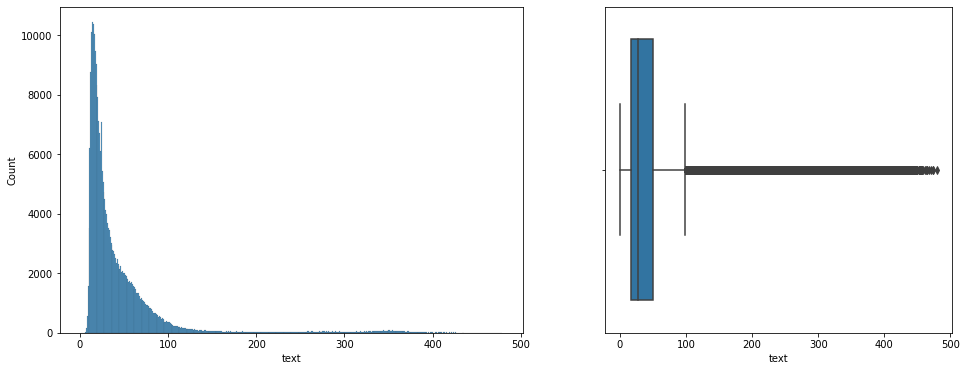

In [ ]:

original_sent_counts = train_data['text'].apply(lambda x: len(x.split(' ')))

fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(original_sent_counts, binwidth=1, ax=axs[0])
sns.boxplot(original_sent_counts, ax=axs[1])

/home/link/miniconda3/envs/kobertsum/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='summary'>

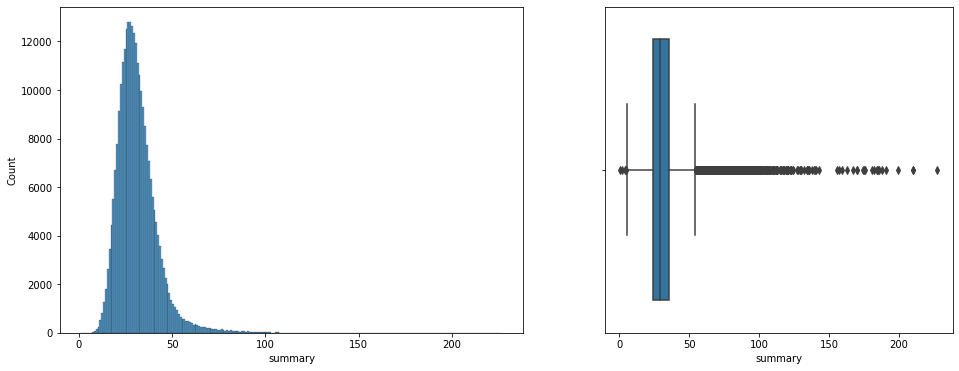

In [ ]:
# sentence
original_sent_counts = train_data['summary'].apply(lambda x: len(x.split(' ')))

fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(original_sent_counts, binwidth=1, ax=axs[0])
sns.boxplot(original_sent_counts, ax=axs[1])

# training

In [ ]:
ROOT_DIR = "/home/link/Project"
PROJECT_DIR = ROOT_DIR + '/KoBertSum_1'
DATA_DIR = PROJECT_DIR + '/datasets/bflysoft_ko'
RAW_DATA_DIR = DATA_DIR + '/raw'
JSON_DATA_DIR = DATA_DIR + '/json'
BERT_DATA_DIR = DATA_DIR + '/bert' 

MODEL_DIR = PROJECT_DIR + '/abs/models'  
LOG_DIR = PROJECT_DIR + '/abs/logs' # logs -> for storing logs information during preprocess and finetuning
RESULT_DIR = PROJECT_DIR + '/abs/result' 

# MERGE_STORY_DIR = PreSumm_DATA_DIR + '/merged_stories_tokenized'  #  tokenized data  
# * **json_data** ->  json files
# * **bert_data** ->  .pt files
# * **logs** ->  for storing logs information during preprocess and finetuning
# * **temp** -> cache model config data
# * **bertsumextabs** ->  save finetuning model weights****

In [ ]:
!python /home/link/Project/KoBertSum_1/src/train.py \
    -task abs -mode train -bert_data_path '/home/link/Project/KoBertSum_1/datasets/bflysoft_ko/bert' \
    -model_path '/home/link/Project/KoBertSum_1/abs/models/kykim_bert_0929_13' \
    -log_file '/home/link/Project/KoBertSum_1/abs/logs'\
    -model_name 'kykim/bert-kor-base' \
    -load_from_extractive '/home/link/Project/KoBertSum_1/ext/models/kykim_bert_0702_13/model_step_2100.pt' \
    -dec_dropout 0.2   -sep_optim true -lr_bert 0.002 -lr_dec 0.2 -save_checkpoint_steps 2000 -batch_size 140 -train_steps 200000 -report_every 50 -accum_count 5 -use_bert_emb true -use_interval true -warmup_steps_bert 20000 -warmup_steps_dec 10000 -max_pos 512 -visible_gpus 0,1 

In [31]:
import os
import re
import json
from typing import Iterable, List
from tqdm import tqdm
from collections.abc import Iterable as itr
import multiprocessing as mp
import functools

import numpy as np
import pandas as pd

def get_n_workers(n_workers, data_len=None):
    if n_workers is None:
        n_cores = mp.cpu_count()
        n_workers = n_cores - 2
    if data_len:  # 최소한 data_len보다 많게 할당하지는 않도록
        n_workers = min(n_workers, data_len)

    # print(f"# Cores to Use: {n_workers}")
    return n_workers


def apply_df_by_row(df, func):
    df = df.apply(lambda row: func(row))
    return df


def mp_df(df, func, by_row=False, n_workers=None):
    n_workers = get_n_workers(n_workers, data_len=len(df))

    df_split = np.array_split(df, n_workers)
    pool = mp.Pool(n_workers)
    if by_row:
        func = functools.partial(
            apply_df_by_row,
            func=func,
        )

    result_df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()

    # # Use Pandaral·lel(https://github.com/nalepae/pandarallel#pandarallel)
    # from pandarallel import pandarallel
    # pandarallel.initialize(nb_workers=n_workers)
    # result_df = df.parallel_apply(func)

    return result_df

def mp_iterable(iterable_data, func, n_workers=None):
    """iterable한 데이터에 대해 element 각각에 func을 적용하는 함수
    df일 경우에는 df를 리턴하고, 다른 iterable type에 대해서는 list를 리턴함
    """
    try:
        iter(iterable_data)
    except TypeError:
        print("The data is not iterable")

    # If iterable_data is df type
    if isinstance(iterable_data, pd.Series):
        result_df = mp_df(iterable_data, func, by_row=True, n_workers=n_workers)
        return result_df

    # If iterable_data is other iterable type
    n_workers = get_n_workers(n_workers, data_len=len(iterable_data))

    pool = mp.Pool(n_workers)
    result_list = pool.map(func, iterable_data)
    pool.close()
    pool.join()

    return result_list

In [28]:
train_data['text'][271000:].values

array(['글로벌 그룹 아이즈원(IZ*ONE)이 사랑과 진심을 가득 담은 새 앨범을 들고 돌아왔다.',
       "키움증권은 1일 효성첨단소재에 대해 '올해 1분기 영업이익이 470억원으로 전 분기 대비 356% 증가할 전망'이라고 분석했다. 투자의견 '매수'와 목표주가 19만원은 유지했다.",
       "하이투자증권은 1일 미국의 장단기 국채금리 역전으로 'R(recession·경기 침체)의 공포'가 확산되고 있지만 현 시점에서는 국내 경기 차별화 현상 심화가 더욱 큰 문제라고 진단했다.",
       '배우 윤지오가 만우절을 빙자해 자신과 가족을 우롱하는 방송과 악플을 올린 누리꾼에 분노했다.',
       '중국의 경기 부양 효과가 심리지표에 반영되기 시작했다. 중국 통계국이 발표하는 제조업 구매자관리지수(PMI)가 반등했다. 대외수요가 여전히 불확실하다는 점에서 최소 7월까지 완화적 정책방향을 유지할 것이라는 전망이 나온다.',
       "실내 공기질 관리 전문 기업 ㈜하츠(Haatz)가 창문을 열 수 없을 때에도 사계절 24시간 자연이 만든 건강한 산소를 공급하는 신개념 청공조기 '에어프레셔(AIR FRESHER)'를 출시했다.",
       "편의점 CU(씨유)가 배달앱 '요기요', 메쉬코리아 '부릉'과 손잡고 배달서비스를 시작한다고 1일 밝혔다.",
       '인공지능(AI) 플랫폼 업체 마인즈랩이 180억원 규모의 상장 전 지분투자(프리IPO) 유치에 성공했다. 이 회사는 내년을 목표로 기업공개(IPO) 절차도 진행한다.',
       '가톨릭혈액병원이 서울성모병원과 여의도성모병원, 은평성모병원을 하나로 잇는 통합 진료 네트워크를 구축한다. 세 병원 340여개 병상을 통합해 운영할 계획이다.',
       "동서대학교(총장 장제국)는 여성가족부와 한국청소년활동진흥원이 주관하는 '2019년 국제청소년리더 교류지원사업' 운영기관으로 최종 선정됐다고 1일 밝혔다.",
       "부산구치소 교정협의회(회장 김진영)는 지난 

In [12]:
func = (lambda x : x)

In [13]:
func("asd")

'asd'

In [33]:


df = train_data['text'][271000:]
func = kss_split_sent
# func = (lambda x : 1)

n_workers = get_n_workers(13, data_len=len(df))

df_split = np.array_split(df, n_workers)
pool = mp.Pool(n_workers)

func = functools.partial(
    apply_df_by_row,
    func=func,
)

pool.map(func, df_split)
# result_df = pd.concat(pool.map(func, df_split))
# pool.close()
# pool.join()

AssertionError: daemonic processes are not allowed to have children

In [17]:
# sentence
original_sent_counts = train_data['text'][271000:].apply(lambda x: len(kss_split_sent(x)))

fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(original_sent_counts, binwidth=1, ax=axs[0])
sns.boxplot(original_sent_counts, ax=axs[1])

Process ForkProcess-19074:
Exception ignored in: <function _releaseLock at 0x7f87c1afc5e0>
Traceback (most recent call last):
  File "/home/link/miniconda3/envs/kobertsum/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkProcess-19076:
Process ForkProcess-19075:
Process ForkProcess-19073:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/link/miniconda3/envs/kobertsum/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/link/miniconda3/envs/kobertsum/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/link/miniconda3/envs/kobertsum/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/link/miniconda3/envs/kobertsum/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [13]:
set(original_sent_counts)

{1, 2}

In [11]:
val_data = train_data.iloc[-4000:, :]
train_data = train_data.iloc[:-4000, :]

In [12]:
train_data["decoder_input"] = train_data["summary"].apply(lambda x : "sostoken " + str(x))
train_data["decoder_target"] = train_data["summary"].apply(lambda x : str(x) + " eostoken")

encoder_input = train_data["text"]
decoder_input = train_data["decoder_input"]
decoder_output = train_data["decoder_target"]

In [13]:
train_data.head()

,id,text,summary,decoder_input,decoder_target
0,0,원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해...,원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 ...,sostoken 원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위...,원고가 주동하여 회사업무능률을 저해하고 회사업무상의 지휘명령에 위반하였다면 이에 ...
1,1,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 같은 그룹내 종합무역상사인 소외 ...,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 소외 회사의 직수출실적을 지원하기...,sostoken 수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 소외 회사의 직수...,수출입업체인 원고가 의류제품을 제조ㆍ수출함에 있어 소외 회사의 직수출실적을 지원하기...
2,2,가등기담보권자가 제소전 화해조항에 따라 자기 명의로 소유권이전의 본등기를 경료한 후...,가등기담보권자가 제소전 화해조항에 의해 자기 명의로 소유권이전의 본등기를 경료하고 ...,sostoken 가등기담보권자가 제소전 화해조항에 의해 자기 명의로 소유권이전의 본...,가등기담보권자가 제소전 화해조항에 의해 자기 명의로 소유권이전의 본등기를 경료하고 ...
3,3,가. 부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 뜻은 ...,부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 의미는 제1...,sostoken 부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한...,부가가치세법 제22조 제3항 단서에 제1호와 제2호가 동시에 해당한다는 의미는 제1...
4,4,소득세법 제116조 제1항의 규정에 의하면 정부는 과세표준확정신고를 하여야 할 자에...,소득세법 제116조 제1항에 따르면 정부는 과세표준확정신고를 해야 할 자에 대해 당...,sostoken 소득세법 제116조 제1항에 따르면 정부는 과세표준확정신고를 해야 ...,소득세법 제116조 제1항에 따르면 정부는 과세표준확정신고를 해야 할 자에 대해 당...


In [14]:
val_data["decoder_input"] = val_data["summary"].apply(lambda x : "sostoken " + x)
val_data["decoder_target"] = val_data["summary"].apply(lambda x : x + " eostoken")

encoder_input_val = val_data["text"]
decoder_input_val = val_data["decoder_input"]
decoder_output_val = val_data["decoder_target"]

In [15]:
val_data.head()

,id,text,summary,decoder_input,decoder_target
267659,267665,지난 14일 서울 광화문에서 열린 '2019 자주통일대회' 행사에서 청소년들이 '자...,지난 14일 서울 광화문에서 민주노총 등 52개 진보단체 연합체인 민중공동행동이 개...,sostoken 지난 14일 서울 광화문에서 민주노총 등 52개 진보단체 연합체인 ...,지난 14일 서울 광화문에서 민주노총 등 52개 진보단체 연합체인 민중공동행동이 개...
267660,267666,2016년 '정운호 게이트' 당시 검찰의 수사상황을 법원행정처에 유출한 혐의로 재판...,2016년 4월 '정운호 게이트' 사건과 관련 검찰의 수사상황을 법원행정처에 공무상...,sostoken 2016년 4월 '정운호 게이트' 사건과 관련 검찰의 수사상황을 법...,2016년 4월 '정운호 게이트' 사건과 관련 검찰의 수사상황을 법원행정처에 공무상...
267661,267667,[서울신문] 미국이 니콜라스 마두로 베네수엘라 정권의 2인자와 비밀 접촉을 했다는 ...,AP통신이 18일(현지시간) 트럼프 정부 측 인사가 베네수엘라 마두로 정권의 서열2...,sostoken AP통신이 18일(현지시간) 트럼프 정부 측 인사가 베네수엘라 마두...,AP통신이 18일(현지시간) 트럼프 정부 측 인사가 베네수엘라 마두로 정권의 서열2...
267662,267668,동양제철화학(OCI) 자회사인 ㈜DCRE가 인천 학익동 옛 공장 터에 아파트 1만 ...,19일 가톨릭환경연대 등 인천지역 환경단체들에 따르면 한강유역환경청은 “인천시가 동...,sostoken 19일 가톨릭환경연대 등 인천지역 환경단체들에 따르면 한강유역환경청...,19일 가톨릭환경연대 등 인천지역 환경단체들에 따르면 한강유역환경청은 “인천시가 동...
267663,267669,[서울신문] 유럽연합(EU)에 이어 유럽자유무역연합(EFTA)도 남미공동시장(메르코...,유럽연합에 이어 유럽자유무역연합도 브라질 정부에게 남미공동시장과의 자유무역협상에 환...,sostoken 유럽연합에 이어 유럽자유무역연합도 브라질 정부에게 남미공동시장과의 ...,유럽연합에 이어 유럽자유무역연합도 브라질 정부에게 남미공동시장과의 자유무역협상에 환...


In [16]:
'''src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input)'''

'src_tokenizer = Tokenizer()\nsrc_tokenizer.fit_on_texts(encoder_input)'

In [17]:
src_vocab = 150000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input)

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input)
encoder_input_val = src_tokenizer.texts_to_sequences(encoder_input_val)

In [18]:
'''tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input)'''

'tar_tokenizer = Tokenizer()\ntar_tokenizer.fit_on_texts(decoder_input)'

In [19]:
tar_vocab = 150000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input)
tar_tokenizer.fit_on_texts(decoder_output)

In [20]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_output)
decoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val)
decoder_target_val = tar_tokenizer.texts_to_sequences(decoder_output_val)

In [21]:
text_max_len = 100
summary_max_len = 100

In [22]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_val = pad_sequences(encoder_input_val, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_val = pad_sequences(decoder_input_val, maxlen = summary_max_len, padding='post')
decoder_target_val = pad_sequences(decoder_target_val, maxlen = summary_max_len, padding='post')

In [23]:
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [24]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [25]:
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     19200000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [26]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [27]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     19200000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train],
                    y = decoder_target_train,
                    validation_data = ([encoder_input_val, decoder_input_val], decoder_target_val),
                    batch_size = 128, callbacks=[es], epochs = 5)

Epoch 1/5
2092/2092 [==============================] - 3242s 2s/step - loss: 2.7283 - val_loss: 2.1907
Epoch 2/5
2092/2092 [==============================] - 3374s 2s/step - loss: 2.2479 - val_loss: 2.0741
Epoch 3/5
2092/2092 [==============================] - 3209s 2s/step - loss: 2.1465 - val_loss: 2.0262
Epoch 4/5
2092/2092 [==============================] - 3208s 2s/step - loss: 2.0968 - val_loss: 1.9954
Epoch 5/5
2092/2092 [==============================] - 3208s 2s/step - loss: 2.0687 - val_loss: 1.9796


In [30]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [31]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [32]:
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

In [33]:
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [34]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [35]:
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

In [36]:
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [37]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [38]:
encoder_input_test = test_data["text"]
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')

In [42]:
from tqdm import tqdm

summary = []
for i in tqdm(range(len(encoder_input_test))):
    summary.append(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

100%|██████████| 10000/10000 [3:32:24<00:00,  1.27s/it] 


In [43]:
sample_submission["summary"] = summary

sample_submission.to_csv("base_submission.csv", index = False)

In [44]:
sample_submission.head()

,id,summary
0,1,지난 15일 시청 상황실에서 열린 '2019 대한민국 우수사례 우수사례 공모에 선...
1,2,정부가 지난 2일 국회 본회의를 통과한 가운데 정부는 내년 1월부터 내년 1월부터...
2,3,지난 20일 오후 2시 30분 앞에서 열린 '2019 대한민국 축구종합센터 유치 ...
3,4,대법원 판결이 대법원 판결을 받은 뒤 지난 7월 말 이후 한 달간 한 달간 대해 ...
4,5,문재인 대통령은 지난 1일 트럼프 대통령이 지난 5월 말 열린 트럼프 대통령의 친...
